In [26]:

# Google earth engine
import ee
# Authenticate and initialize Earth Engine API
#ee.Authenticate()  # Only required once
ee.Initialize(
      opt_url='https://earthengine-highvolume.googleapis.com'
)

# Built-in modules
import os
import subprocess
from pathlib import Path
import datetime
from datetime import date
from urllib.request import urlopen
from typing import Any, Optional, Tuple

# Basics of Python data handling and visualization
import math
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Geospatial
import geemap
import geopandas as gpd
from shapely import wkt
from shapely.geometry import (
    shape,
    Point,
    LineString,
    Polygon,
    MultiPoint,
    MultiLineString,
    MultiPolygon
)
from shapely.validation import make_valid
import geojson
import folium
from geopy.distance import great_circle
from gadm import GADMDownloader
import rasterio
from rasterio import plot
import xarray as xr  # It may need Dask library https://docs.dask.org/en/stable/install.html
import rioxarray  # noqa: F401 # Its necesary for xarray.open_mfdataset() with engine `rasterio`


# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import (
    get_adjacent_blocks, 
    get_new_adjacent_blocks,
    plot_block_and_adjacent, 
    expand_network
)


ImportError: cannot import name 'expand_network' from 'utils' (/Users/paulgubbins/Documents/Github/cfi-map2-grids-ee/notebooks/utils.py)

In [2]:
# GLOBAL PARAMS:

# Country: Select one of: ["Brazil", "India", "Indonesia", "Ethiopia", "Nigeria"]
COUNTRY = "Nigeria"

# FILE PATHS (GLOBALS)
cdir = os.getcwd()
pdir = os.path.dirname(cdir)
OUTPUTS_FOLDER = os.path.join(pdir, "outputs", COUNTRY)

In [9]:
# Open sampling grid for selected country

file = os.path.join(OUTPUTS_FOLDER, "final_sampling_grid.geojson")
# Convert to geopandas dataframe
sampling_grid = gpd.read_file(file)
# Select only blocks in sample 
initial_sample = sampling_grid[sampling_grid['in_sample'] == 1]


Blocks adjacent to 5157: ['4974' '4975' '4976' '5156' '5158' '5338' '5339' '5340']


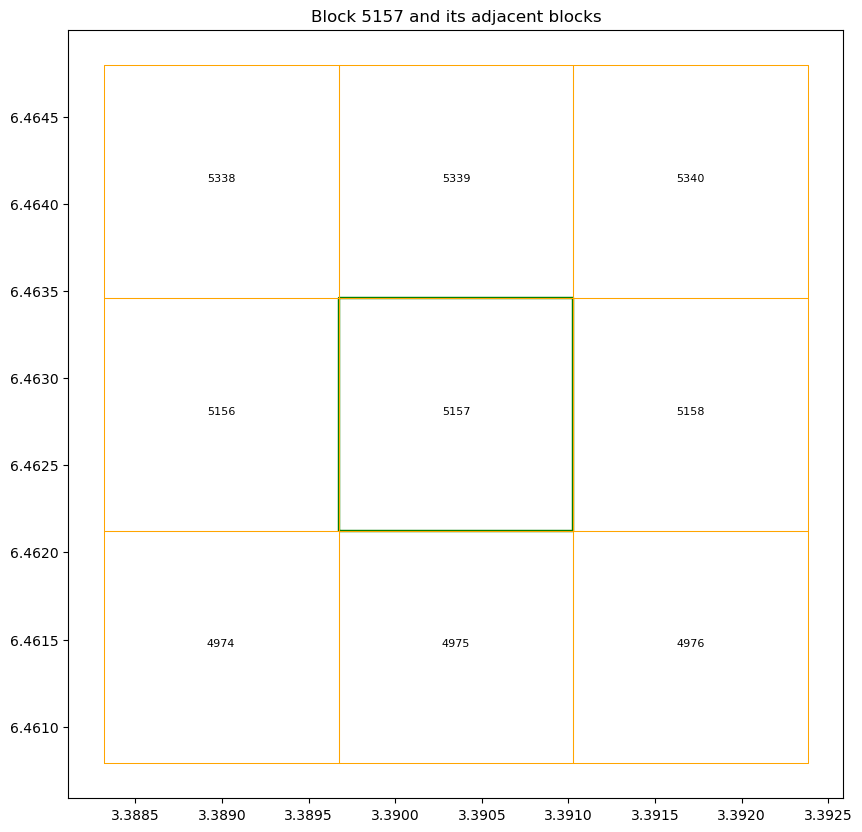

In [17]:
# Testing functions that plot the block and its adjacent blocks

# Randomly select N rows from the built_blocks_gdf dataframe
from numpy.random import RandomState
prng = RandomState(1234567890)

# Randomly select a single block (the origin) from the initial sample
origin_block_id = initial_sample.sample(n=1, random_state=prng)['block_id'].values[0]

# Return a list of all adjacent blocks to the selected block
adjacent_blocks_list = get_adjacent_blocks(origin_block_id, sampling_grid)['block_id'].values
print(f"Blocks adjacent to {origin_block_id}: {adjacent_blocks_list}")

# Plot the block and its adjacent blocks
plot_block_and_adjacent(origin_block_id, sampling_grid)


<Axes: >

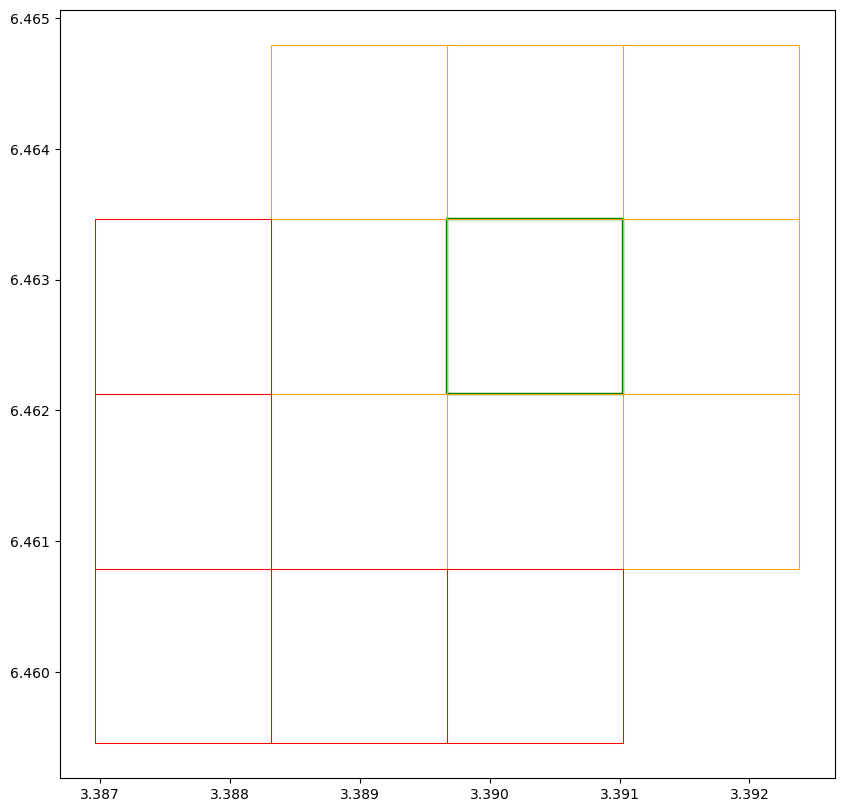

In [20]:
# Return adjancet blocks in a second expansion

origin_gdf = sampling_grid[sampling_grid['block_id'] == origin_block_id]
adjacent_blocks_gdf = get_adjacent_blocks(origin_block_id, sampling_grid)
network = pd.concat([origin_gdf, adjacent_blocks_gdf])

edge_block_id = '4974'
new_adjacenet_blocks_gdf = get_new_adjacent_blocks(edge_block_id, network, sampling_grid)
new_network = pd.concat([network, new_adjacenet_blocks_gdf])

# Plot the network
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the block
origin_gdf.boundary.plot(ax=ax, color="green", linewidth = 1.75, aspect = 1)
# Plot the adjacent blocks
adjacent_blocks_gdf.boundary.plot(ax=ax, color="orange", linewidth = 0.75)
# Plot the new adjacent blocks
new_adjacenet_blocks_gdf.boundary.plot(ax=ax, color="red", linewidth = 0.75)

In [21]:
####################################################################
# VISUALIZE NETWORK
###################################################################

# Converting assets to ee objects
origin_ee = geemap.gdf_to_ee(origin_gdf)
adjacent_blocks_ee = geemap.gdf_to_ee(adjacent_blocks_gdf)
new_adjacenet_blocks_ee = geemap.gdf_to_ee(new_adjacenet_blocks_gdf)
network_ee = geemap.gdf_to_ee(new_network)

m = geemap.Map()
m.centerObject(network_ee, 14)

########################
# BLOCK NETWORK
########################

# Add origin block to the map
m.add_layer(origin_ee, {'color': 'green', "width": 2}, "Origin block")
m.add_layer(adjacent_blocks_ee, {'color': 'orange', "width": 2}, "1st expansion")
m.add_layer(new_adjacenet_blocks_ee, {'color': 'red', "width": 2}, "2nd expansion")

m

Map(center=[6.462125498222141, 3.3896724977096016], controls=(WidgetControl(options=['position', 'transparent_…